In [1]:
from timeit import default_timer as timer
import warnings

import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tools.sm_exceptions import DomainWarning

import acsbm

# ignore DomainWarning from statsmodels. We know...
warnings.simplefilter("ignore", DomainWarning)

In [2]:
def run_simulation(model, ndd, n, ignore_covariates=False, ignore_communities=False):
    net = acsbm.generate_network(model, ndd, n)

    k = 1 if ignore_communities else model.n_communities
    d = len(net.block_sizes)

    # Show model, network
    if n <= 1000:
        plt.matshow(net.A.toarray())
    plt.matshow(model.B_tilde())
    plt.colorbar()

    # Ignore covariates?
    if ignore_covariates:
        net.Z_tilde = np.zeros_like(net.Z_tilde)

    # Cluster!
    start = timer()
    ic_result = acsbm.initial_cluster(net, k, d)
    mid = timer()
    c_result = acsbm.reconcile_clusters(net, ic_result)
    end = timer()
    
    # Report clustering accuracy only if not ignoring communities (in which case accuracy is meaningless)
    if not ignore_communities:
        print(f"Accuracy: {acsbm.label_accuracy(c_result.theta, net.theta)}")
        print(f"Clustering Time: {mid-start} + {end-mid} = {end-start}")

    # Estimate coefficients (unless ignoring covariates)
    if not ignore_covariates:
        start = timer()
        e_result = acsbm.estimate(net, c_result)
        end = timer()

        plt.matshow(c_result.B_tilde)
        plt.colorbar()
        plt.matshow(e_result.B_hat)
        plt.colorbar()

        print(f"Coefficients: {e_result.coefficients}")
        print(f"Estimation Time: {end-start}")

# Example 1: Three Binary Covariates with Mixed Homophily Effects

/usr/local/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


IndexError: index 16 is out of bounds for axis 0 with size 16

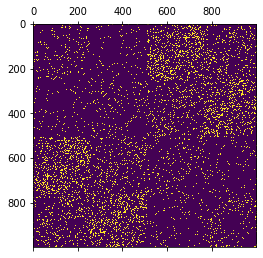

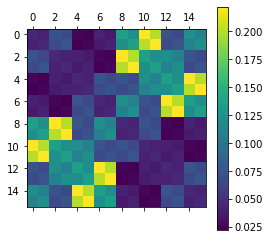

In [3]:
model = acsbm.MultiCovariateModel(
    B=np.log(-0.2 * np.eye(2) + 0.3) - 1,
    covariates=[
        acsbm.Covariate.simple(0.6, 2),
        acsbm.Covariate.simple(-0.5, 2),
        acsbm.Covariate.simple(0.1, 2)
    ],
    link=acsbm.LinkFunction.log()
)
ndd = acsbm.NodeDataDistribution.uniform_for_model(model)

run_simulation(model, ndd, 1000) # note: works fine with ignore_covariates=True or ignore_communities=True

# Example 2: Similar to the Simpson's Paradox Example

Accuracy: 1.0
Clustering Time: 0.6396639359882101
Coefficients: [-1.01749902]
Estimation Time: 0.07083613297436386


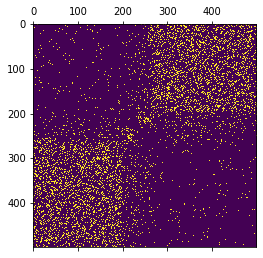

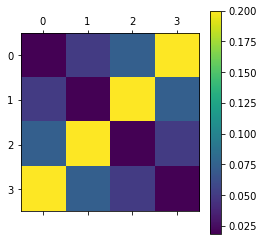

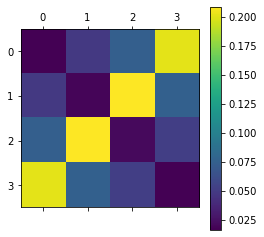

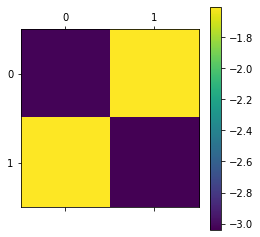

In [4]:
model = acsbm.MultiCovariateModel(
    B=np.log(-.15 * np.eye(2) + 0.2),
    covariates=[acsbm.Covariate.simple(-1, 2)],
    link=acsbm.LinkFunction.log()
)
ndd = acsbm.NodeDataDistribution(np.array([
    [6, 1],
    [1, 6]
]))

run_simulation(model, ndd, 500, ignore_communities=False) # ignore_communities=True results in biased estimate

# Example 3: Covariate Effect Dwarfs Latent Community Structure

Accuracy: 0.503
Clustering Time: 0.4336325380136259


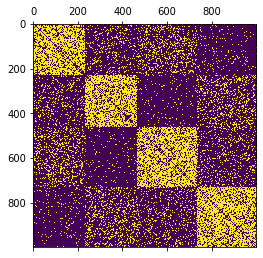

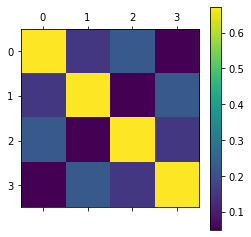

In [5]:
model = acsbm.MultiCovariateModel(B=np.log(.1 * np.eye(2) + 0.05), covariates=[acsbm.Covariate.simple(1.5, 2)], link=acsbm.LinkFunction.log())
ndd = acsbm.NodeDataDistribution.uniform_for_model(model)

run_simulation(model, ndd, 1000, ignore_covariates=True) # ignore_covariates results in terrible accuracy

## Example 3b: Simpson's Paradox

Accuracy: 1.0
Clustering Time: 0.5820680590113625
Coefficients: [-0.50934762]
Estimation Time: 0.1708074560156092


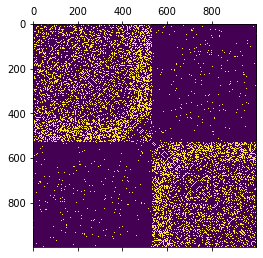

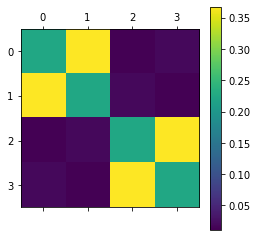

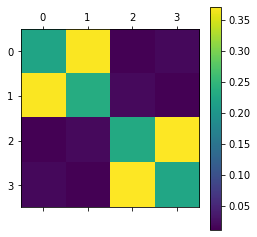

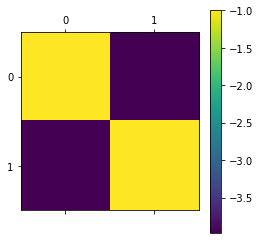

In [6]:
model = acsbm.MultiCovariateModel(B=(3 * np.eye(2) - 4), covariates=[acsbm.Covariate.simple(-0.5, 2)], link=acsbm.LinkFunction.log())
ndd = acsbm.NodeDataDistribution(np.array([[4, 1], [1, 4]]))

run_simulation(model, ndd, 1000) # ignore_communities = True flips sign of estimated coefficient

# Example 4: Random pmf, Two Covariates

Accuracy: 0.922
Clustering Time: 1.4292346650036052
Coefficients: [ 0.49350207 -0.45650962]
Estimation Time: 0.13375062600243837


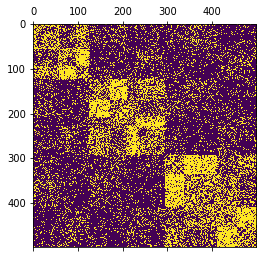

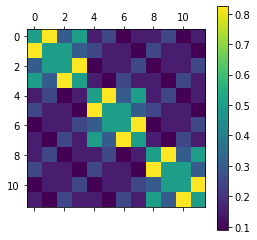

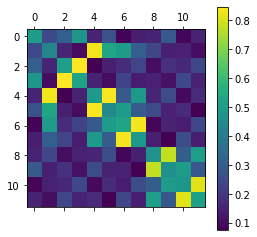

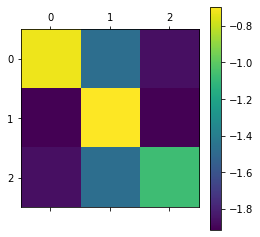

In [7]:
model = acsbm.MultiCovariateModel(
    B=np.log(.35 * np.eye(3) + 0.15),
    covariates=[acsbm.Covariate.simple(0.5, 2), acsbm.Covariate.simple(-0.5, 2)],
    link=acsbm.LinkFunction.log()
)
ndd = acsbm.NodeDataDistribution.random_for_model(model)

run_simulation(model, ndd, 500)

# Example 5: Logit

Accuracy: 1.0
Clustering Time: 2.7880291279871017
Coefficients: [ 1.98956889 -0.9948991   0.51224377]
Estimation Time: 0.16875304200220853


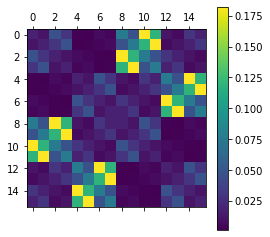

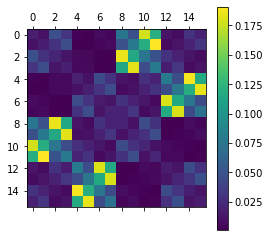

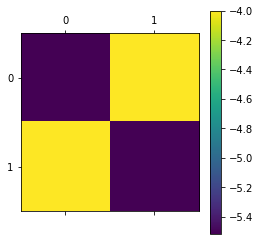

In [8]:
model = acsbm.MultiCovariateModel(
    B=-1.5 * np.eye(2) - 4,
    covariates=[acsbm.Covariate.simple(2, 2), acsbm.Covariate.simple(-1, 2), acsbm.Covariate.simple(0.5, 2)],
    link=acsbm.LinkFunction.logit()
)
ndd = acsbm.NodeDataDistribution.uniform_for_model(model)

run_simulation(model, ndd, 2000) # ignore_covariates = True breaks accuracy

# Example 6: Non-Symmetric Underlying SBM

Accuracy: 1.0
Clustering Time: 0.914228001027368
Coefficients: [ 0.47832369 -0.49694293]
Estimation Time: 0.09382670297054574


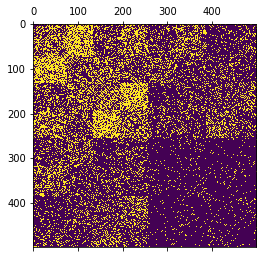

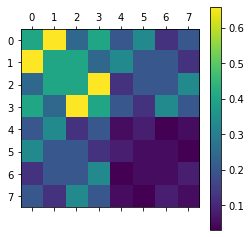

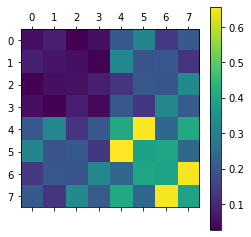

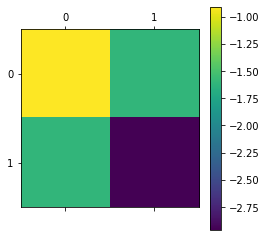

In [9]:
model = acsbm.MultiCovariateModel(
    B=np.log(np.array([
        [0.4, 0.2],
        [0.2, 0.05]
    ])),
    covariates=[acsbm.Covariate.simple(0.5, 2), acsbm.Covariate.simple(-0.5, 2)],
    link=acsbm.LinkFunction.log()
)
ndd = acsbm.NodeDataDistribution.uniform_for_model(model)

run_simulation(model, ndd, 500) # ignore_covariates=True hurts accuracy

# Example 7: Probit Link

Accuracy: 1.0
Clustering Time: 2.620757235970814
Coefficients: [ 0.90174202 -0.70073307  0.10497927]
Estimation Time: 0.19291952898493037


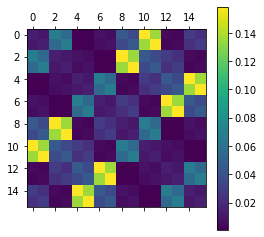

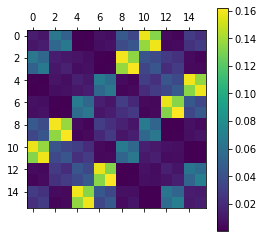

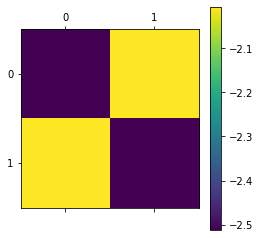

In [10]:
model = acsbm.MultiCovariateModel(
    B=-0.5 * np.eye(2) - 2,
    covariates=[
        acsbm.Covariate.simple(0.9, 2),
        acsbm.Covariate.simple(-0.7, 2),
        acsbm.Covariate.simple(0.1, 2)
    ],
    link=acsbm.LinkFunction.probit()
)
ndd = acsbm.NodeDataDistribution.uniform_for_model(model)

run_simulation(model, ndd, 2000) # ignore_covariates=True hurts accuracy

# Example 8: Identity Link

Accuracy: 0.998
Clustering Time: 2.307789011974819
Coefficients: [ 0.19958393 -0.20058771  0.00852099]
Estimation Time: 0.33783175196731463


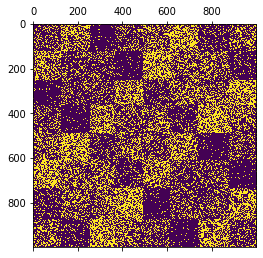

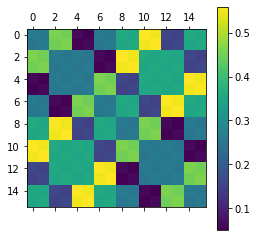

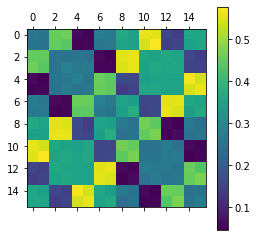

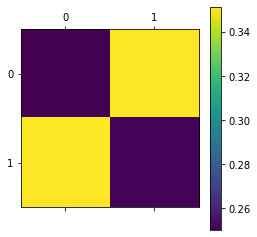

In [11]:
model = acsbm.MultiCovariateModel(
    B=-0.1 * np.eye(2) + 0.35,
    covariates=[
        acsbm.Covariate.simple(0.2, 2),
        acsbm.Covariate.simple(-0.2, 2),
        acsbm.Covariate.simple(0.01, 2)
    ],
    link=acsbm.LinkFunction.identity()
)
ndd = acsbm.NodeDataDistribution.uniform_for_model(model)

run_simulation(model, ndd, 1000, ignore_covariates=False) # ignore_covariates=True hurts accuracy